# Regulome Explorer Notebook 2.1

Gene-gene correlations using PanCancer expression and copy number data.


## Auth Setup & Function Defs

### Authenticate with Google  (IMPORTANT)
Our first step is to authenticate with Google -- you will need to be a member of a Google Cloud Platform (GCP) project, with authorization to run BigQuery jobs in order to run this notebook.  If you don't have access to a GCP project, please contact the ISB-CGC team for help (www.isb-cgc.org)



In [ ]:
from google.colab import auth
from google.cloud import bigquery

def cgcAuth(project):
  try:
    auth.authenticate_user()
    print('You have been successfully authenticated!')
  except:
    print('You have not been authenticated.')
  
  try:
    project_id = 'isb-cgc-02-0001'
    bqclient = bigquery.Client(project=project_id)
    print('BigQuery client successfully initialized')
  except:
    print('Failure to initialize BigQuery client')
  
  return(bqclient)


### Software Configuration

Unless any part of this section fails to run, you only need to look at this in detail if you are interested in understanding how this notebook works or in modifying it for your own purposes.  

Note that running this section alone will take about **5 minutes** due to the sizes of some of the libraries being imported, as well as the number of dependent libraries.  

Of course, once this section has been run, you will be able to run, modify, and re-run any of the later sections of this notebook without having to come back and rerun this section (as long as you have not lost your connection to the Jupyter server).

#### Import Python libraries

Import NumPy, Pandas, and seaborn

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from   ipywidgets import Layout


#### Python convenience functions

We define two convenience functions here:

- **`runQuery`**: a relatively generic BigQuery query-execution wrapper function which can be used to run a query in "dry-run"  mode or not:  the call to the `query()` function itself is inside a `try/except` block and if it fails we return `None`;  otherwise a "dry" will return an empty dataframe, and a "live" run will return the query results as a dataframe

- **`checkQueryResults`**: a generic function that makes sure that what was returned is a dataframe, and checks how many rows are in the returned dataframe

In [ ]:
def runQuery ( client, qString, dryRun=False ):
  
  print ( "\n in runQuery ... " )
  if ( dryRun ):
    print ( "    dry-run only " )
    
  ## set up QueryJobConfig object
  job_config = bigquery.QueryJobConfig()
  job_config.dry_run = dryRun
  job_config.use_query_cache = True
  job_config.use_legacy_sql = False
  
  ## run the query
  try:
    query_job = client.query ( qString, job_config=job_config )
    ## print ( "    query job state: ", query_job.state )
  except:
    print ( "  FATAL ERROR: query execution failed " )
    return ( None )
  
  ## return results as a dataframe (or an empty dataframe for a dry-run) 
  if ( not dryRun ):
    try:
      df = query_job.to_dataframe()
      if ( query_job.total_bytes_processed==0 ):
        print ( "    the results for this query were previously cached " )
      else:
        print ( "    this query processed {} bytes ".format(query_job.total_bytes_processed) )
      if ( len(df) < 1 ):
        print ( "  WARNING: this query returned NO results ")
      return ( df )
    except:
      print ( "  FATAL ERROR: query execution failed " )
      return ( None )
    
  else:
    print ( "    if not cached, this query will process {} bytes ".format(query_job.total_bytes_processed) )
    ## return an empty dataframe
    return ( pd.DataFrame() )
 


def checkQueryResults ( qr ):
  print ( "\n in checkQueryResults ... " )
  if ( not isinstance(qr, pd.DataFrame) ):
    print ( " query execution failed! " )
    return ( False )
  else:
    if ( len(qr) > 0 ): 
      print ( " # of rows in query results: {} ".format(len(qr)) )
      print ( "\n", qr.head() )
    else:
      print ( " query returned NO results ?!? " )  
    return ( True )

### SQL Building Functions


In [ ]:
def build_cohort ( study ):
  qString = """
      WITH
        --
        -- we start with the clinical table
        --
        cohort AS (
        SELECT
          acronym as Study,
          bcr_patient_barcode as ParticipantBarcode
        FROM
          `isb-cgc-01-0008.Filtered.clinical_PANCAN_patient_with_followup_filtered` 
         WHERE
          acronym = '__study__'
          )
          """.replace('__study__',study)
  return(qString)
  

In [ ]:
def select_genes ( dtype, n ):
  if dtype == 'expr':
    qString = """
      selected_genes AS (
      SELECT
        Symbol,
        STDDEV(normalized_count) AS sigmaExp
      FROM
        `isb-cgc-01-0008.Filtered.EBpp_AdjustPANCAN_RNASeqV2_filtered`
      WHERE
        Symbol IS NOT NULL
        AND ParticipantBarcode IN (
          SELECT
            ParticipantBarcode
          FROM
            cohort)
      GROUP BY
        1
      ORDER BY
        sigmaExp DESC
      LIMIT
        __n__ )
      """.replace('__n__', str(n))
    
  elif dtype == 'cnv':
    qString = """
      selected_genes AS (
      SELECT
        Gene_Symbols as Symbol,
        STDDEV(GISTIC_Calls) AS sigmaExp
      FROM
        `isb-cgc-01-0008.Filtered.all_CNVR_data_by_gene_filtered`
      WHERE
        Symbol IS NOT NULL
        AND ParticipantBarcode IN (
          SELECT
            ParticipantBarcode
          FROM
            cohort)
      GROUP BY
        1
      ORDER BY
        sigmaExp DESC
      LIMIT
        __n__ )
      """.replace('__n__', str(n))
  else:
    # 
    # Could be some other gene selection function here ##
    #
    qString = ''
  return(qString)

In [ ]:
def get_expr_data():
  qString = """
      expr_data AS (
      SELECT
        Symbol,
        ParticipantBarcode,
        SampleBarcode,
        normalized_count as expr,
        DENSE_RANK() OVER (PARTITION BY SampleBarcode ORDER BY normalized_count ASC) AS rankExpr
      FROM
        `isb-cgc-01-0008.Filtered.EBpp_AdjustPANCAN_RNASeqV2_filtered`
      WHERE
        Symbol IS NOT NULL AND
        Symbol IN (
          SELECT
            Symbol
          FROM
            selected_genes)
        AND ParticipantBarcode IN (
          SELECT
            ParticipantBarcode
          FROM
            cohort) 
      )
  """
  return(qString)


In [ ]:
def get_cnv_data():
  qString = """
      cnv_data AS (
      SELECT
        Gene_Symbol as Symbol,
        ParticipantBarcode,
        SampleBarcode,
        GISTIC_Calls as cnv,
        DENSE_RANK() OVER (PARTITION BY SampleBarcode ORDER BY GISTIC_Calls ASC) AS rankCNV
      FROM
        `isb-cgc-01-0008.Filtered.all_CNVR_data_by_gene_filtered`
      WHERE
  	   Gene_Symbol IS NOT NULL AND
       Gene_Symbol IN (
        SELECT
          Symbol AS Gene_Symbol
        FROM
          selected_genes)
       AND ParticipantBarcode IN (
        SELECT
       ParticipantBarcode
        FROM
       cohort) 
       )
  """
  return(qString)



In [ ]:
  def join_data():
    qString = """
      j_data AS (
      SELECT
        expr_data.Symbol as Symbol,
        expr_data.SampleBarcode as SampleBarcode,
        expr,
        rankExpr,
        cnv,
        rankCNV
      FROM
        expr_data JOIN cnv_data
      ON
        expr_data.SampleBarcode = cnv_data.SampleBarcode
        AND expr_data.Symbol = cnv_data.Symbol 
      )
    """
    return(qString)

In [ ]:
def comp_corr():
  qString = """
  corr_table AS (
  SELECT
    Symbol,
    CORR(rankExpr,rankCNV) AS corr
  FROM
    j_data
  GROUP BY
    1
  ORDER BY
    corr DESC
    )
  """
  return(qString)


In [ ]:
def final( last_table ):
  qString = """
  SELECT * FROM __last_table__
  """.replace('__last_table__', last_table)
  return(qString)


In [ ]:
def build_query( study, dtype, size ):
  sql = (
    build_cohort( study ) + ',\n' +
    select_genes ( dtype, size ) + ',' +
    get_expr_data() + ',\n' +
    get_cnv_data() + ',\n' +
    join_data() + ',\n' +
    comp_corr() + '\n' +
    final( 'corr_table' )
  )
  return(sql)

###Widget definitions

In [ ]:
# here we return a list of the widgets
# which hold user defined values.

def makeWidgets():
  studyList = [ 'ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 
                'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 
                'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 
                'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 
                'UVM' ]

  study = widgets.Dropdown(
      options=studyList,
      value='COAD',
      description='',
      disabled=False
      )

  # choosing which genes to look at
  vartype = widgets.Dropdown(
      options=['expr', 'cnv'],
      value='expr',
      description='',    
      disabled=False
  )

  size = widgets.IntSlider(value=10, 
                           min=2, 
                           max=100,
                           description=''
                          )  # the n most variable genes
  #
  study_title = widgets.HTML('<em>Select a study </em>')
  display(widgets.HBox([study_title, study]))
  #
  vartype_title = widgets.HTML('<em>Data type to sort results by </em>')
  display(widgets.HBox([vartype_title, vartype]))
  #
  size_title = widgets.HTML('<em>Number of genes </em>')
  display(widgets.HBox([size_title, size]))
  return([study, vartype, size])
  #

##  Start Analysis



In [ ]:
# Start by getting authorized.

bqclient = cgcAuth( project='isb-cgc-02-0001' )

You have been successfully authenticated!
BigQuery client successfully initialized


**Choose a TCGA study, number of genes, and the data source to use in ranking genes.**

In [ ]:
[study, vartype, size] = makeWidgets()

In [ ]:
# building the query string

sql = build_query ( study.value, vartype.value, size.value )

In [ ]:
# calling Google! #

res0 = runQuery ( bqclient, sql, dryRun=False )


 in runQuery ... 
    this query processed 23098505631 bytes 


## Results


In [ ]:
res0.shape

(17, 2)

In [ ]:
res0['index'] = range(0,17)

In [ ]:
res0[1:5]

,Symbol,corr,index
1,EEF1A1,0.359101,1
2,FN1,0.236441,2
3,COL3A1,0.198908,3
4,GFAP,0.195650,4


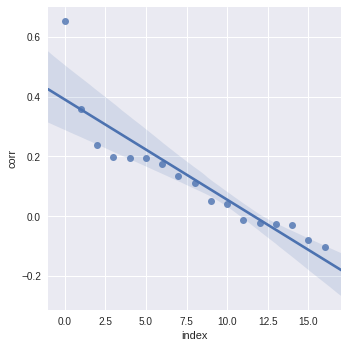

In [ ]:
import seaborn as sns
sns.set(style = 'darkgrid')

sns.lmplot(x='index', y='corr', data=res0)

---